# Pricing Analysis

#### Objective
This project's objective is to analyze the pricing of some products and determine if they are priced correctly. Furthermore, we aim to show what is the best price for each product.

#### Tools
`Pandas`, `Numpy`, `PyGAM`, `StatsModels`, `Scikit-Learn`, `ggplot`.

## Imports

In [1]:
# Data Wrangling
import pandas as pd
import numpy as np

# Data Visualization
from plotnine import *
import plotly_express as px

# Modeling
from sklearn.preprocessing import LabelEncoder
from pygam import GAM, ExpectileGAM, s, l, f
import statsmodels.api as sm

import warnings
warnings.simplefilter('ignore')

## Load Data

In [2]:
# load dataset
file_ = '../.data/financial_sample2.xlsx'
df = pd.read_excel(file_)

print(f'Data Shape: {df.shape}')

# View data head
df.sample(3)

Data Shape: (2800, 10)


,Segment,Product,discount,Quantity,price,Sales,Date,mth_num,mth_name,yr
1955,Midmarket,Velo,High,772.0,22.010616,16992.195330,2014-04-01,4,April,2014
2373,Midmarket,VTT,High,724.0,6.589074,4770.489273,2014-06-01,6,June,2014
503,Channel Partners,Carretera,High,3210.0,13.169727,42274.824040,2013-10-01,10,October,2013


In [3]:
df.dtypes

Segment             object
Product             object
discount            object
Quantity           float64
price              float64
Sales              float64
Date        datetime64[ns]
mth_num              int64
mth_name            object
yr                   int64
dtype: object

In [4]:
# There are NAs only in `discount`, when there is no discount.
# We will replace those NAs with "No Discount"
df.fillna("No Discount", inplace=True)

In [5]:
# Statistical description
df.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
Segment,2800,5,Government,1200,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Product,2800,6,Paseo,808,NaN,NaN,NaN,NaN,NaN,NaN,NaN
discount,2800,4,High,980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,2800.0,NaN,NaN,NaN,1011.963594,145.0,346.0,662.632642,1254.469773,7979.0,1061.547181
price,2800.0,NaN,NaN,NaN,22.576275,1.0,9.440982,18.529493,37.216872,51.97611,14.726118
Sales,2800.0,NaN,NaN,NaN,16775.314162,889.086541,6380.881285,11345.658475,19390.813627,127546.4141,15857.64593
Date,2800,NaN,NaN,NaN,2014-04-28 21:36:00,2013-09-01 00:00:00,2013-12-24 06:00:00,2014-05-16 12:00:00,2014-09-08 12:00:00,2014-12-01 00:00:00,NaN
mth_num,2800.0,NaN,NaN,NaN,7.9,1.0,5.75,9.0,10.25,12.0,3.37551
mth_name,2800,12,October,560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yr,2800.0,NaN,NaN,NaN,2013.75,2013.0,2013.75,2014.0,2014.0,2014.0,0.43309


* No major concerns, no apparent errors in the data.
* The biggest variances are in `Sales` and `Quantity` numbers, which are skewed to the right.
* The top product is *Paseo* and the top segment is *Government*.

## Exploratory Analysis

In [6]:
# Exploring the relationship between price and units sold
fig = px.scatter(
    df, 
    x= 'price', y = 'Quantity',
    color= 'Product',
    opacity=0.5,
    trendline='lowess',
    # trendline_color_override='blue',
    title= 'Price vs Quantity Analysis',
    width=900,
    height=500,
    color_discrete_sequence=px.colors.qualitative.G10
).update_traces(
    marker= dict(size=7),
    hoverlabel= dict(font= dict(size=10))
).update_xaxes(
    title_text = 'Price',
    tickfont= dict(size=10)
).update_yaxes(
    title_text = 'Quantity Sold',
    tickfont= dict(size=10)
)

# Show figure
fig

##### Price-Demand elasticity
It's calculated by dividing the percentage change in quantity demanded by the percentage change in price.

In [7]:
# Calculating Price-Demand elasticity
(
    df
    .groupby('Product')
    .agg({'price': ['max', 'min'],
          'Quantity': ['max', 'min'],
          'Product':'count'})
    .reset_index()
    .pipe(lambda d: d.set_axis(['Product', 'price_max', 'price_min', 'qty_max', 'qty_min', 'obs_count'], axis=1))
    .assign(pct_change_price=lambda d: (d['price_max'] - d['price_min']) / d['price_min'] * 100,
            pct_change_qty  =lambda d: (d['qty_max'] - d['qty_min']) / d['qty_min'] * 100)
    .assign(
         ratio=lambda d: d['pct_change_qty'] / d['pct_change_price']) # demand elasticity
    .sort_values('ratio', ascending=False)
)

,Product,price_max,price_min,qty_max,qty_min,obs_count,pct_change_price,pct_change_qty,ratio
3,Paseo,51.976110,31.286696,2268.023316,145.0,808,66.128470,1464.154011,22.141054
5,Velo,36.946751,19.106243,2489.000000,197.0,436,93.375282,1163.451777,12.459955
0,Amarilla,14.673598,3.143178,4384.878030,215.0,376,366.839554,1939.478153,5.286993
4,VTT,26.950991,5.001823,2151.237279,165.0,436,438.823349,1203.780169,2.743200
2,Montana,16.994412,1.000000,7979.000000,213.0,372,1599.441152,3646.009390,2.279552
1,Carretera,24.592797,1.294622,7913.000000,209.0,372,1799.612407,3686.124402,2.048288


In [8]:
# Exploring the relationship between price and units sold conditioned on the Discounts
fig = px.scatter(
    df, 
    x= 'price', y = 'Quantity',
    color= 'discount',
    facet_col= 'Product',
    facet_col_wrap=2,
    facet_col_spacing=0.1,
    facet_row_spacing=0.15,
    opacity=0.5,
    trendline='lowess',
    title= 'Price vs Quantity | Discount Analysis',
    width=1000,
    height=800,
    color_discrete_sequence=px.colors.qualitative.G10
).update_traces(
    marker= dict(size=7),
    hoverlabel= dict(font= dict(size=10))
).update_xaxes(
    title_text = 'Price',
    tickfont= dict(size=10)
).update_yaxes(
    title_text = 'Quantity Sold',
    tickfont= dict(size=10)
)

fig.for_each_yaxis(lambda yaxis: yaxis.update(showticklabels=True)) #show ticks
fig.for_each_xaxis(lambda xaxis: xaxis.update(showticklabels=True)) #show ticks
fig.update_yaxes(matches=None) # don't share y axis
fig.update_xaxes(matches=None) # don't share x axis

# Show figure
fig

## Modeling Event Impact

In [9]:
# Encoding the data
df_encoded = df.copy()

# One Hot Encoding the events and products
df_encoded = pd.get_dummies(df_encoded,
                            columns= ['discount', 'Product'],
                            drop_first=False)

# Get column names Events
colnames_event = df_encoded.columns[df_encoded.columns.str.startswith('discount')].tolist()
# From boolean to integer
df_encoded[colnames_event] = df_encoded[colnames_event].astype(int)

# Get column names Products
colnames_product = df_encoded.columns[df_encoded.columns.str.startswith('Product')].tolist()
# From boolean to integer
df_encoded[colnames_product] = df_encoded[colnames_product].astype(int)


In [10]:
df_encoded.drop(['Date', 'mth_num', 'mth_name', 'yr', 'Segment'], axis=1).head(2)

,Quantity,price,Sales,discount_High,discount_Low,discount_Medium,discount_No Discount,Product_Amarilla,Product_Carretera,Product_Montana,Product_Paseo,Product_VTT,Product_Velo
0,4178.151185,3.462242,14465.77121,1,0,0,0,1,0,0,0,0,0
1,3469.852007,4.166472,14457.04249,1,0,0,0,1,0,0,0,0,0


In [11]:
# X & y for modeling
X = df_encoded[['price'] + colnames_event + colnames_product]
X = sm.add_constant(X) # adding intercept
y = df_encoded['Quantity']

# Model Fit
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     345.3
Date:                Fri, 11 Jul 2025   Prob (F-statistic):               0.00
Time:                        12:44:43   Log-Likelihood:                -22433.
No. Observations:                2800   AIC:                         4.489e+04
Df Residuals:                    2790   BIC:                         4.495e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  780.8930 

In [12]:
# Getting the Effects (parameters) from each variable
params_df = pd.DataFrame(model.params).T
params_df

,const,price,discount_High,discount_Low,discount_Medium,discount_No Discount,Product_Amarilla,Product_Carretera,Product_Montana,Product_Paseo,Product_VTT,Product_Velo
0,780.893033,-11.596438,1206.942656,-219.975466,139.009688,-345.083846,724.006837,265.291095,104.32785,8.745538,-321.262391,-0.215897


In [13]:
# Estimating the price effects ratio
(params_df['discount_High'] + params_df['const']) / (params_df['discount_No Discount'] + params_df['const'])

0    4.561252
dtype: float64

The effect of the *High* price discount is approximatelly **5 times higher** than the prices with *No discount*.

In [14]:
(params_df['discount_High'] + params_df['const'])

0    1987.835689
dtype: float64

In [15]:
(params_df['discount_No Discount'] + params_df['const'])

0    435.809187
dtype: float64

## Modeling with GAM

GAM (Generalized Additive Model) is an additive modeling technique where the impact of the predictive variables is captured through smooth functions.

In [16]:
# Filtering data
data_filtered = df.query('discount == "No Discount"')

# List of products in our data
unique_prod = data_filtered['Product'].unique()

# Create an empty dataframe to store results
all_gam_results = pd.DataFrame()

In [50]:
# Loop through products
for product in unique_prod:
    # Filter for current product
    product_data = data_filtered.query('Product == @product')

    # Predictors & target split
    X = product_data[['price']]
    y = product_data['Quantity']

    # List of quantiles for modeling
    quantiles = [0.025, 0.5, 0.975]
    gam_results = {}

    # Fit the GAM model
    for q in quantiles:
        gam = ExpectileGAM(s(0), expectile=q) # instance the model
        gam.fit(X,y) #fit
        gam_results[f'pred_{q}'] = gam.predict(X) #predict for that quantile
        print(q, "|", product, "|", gam.deviance_residuals(X,y).mean())
    print("-----------\n")

    # Store the results in a DF
    predictions_gam = pd.DataFrame(gam_results).set_index(X.index)

    # Concatenate results column-wise with the original data
    predictions_gam_df = pd.concat([product_data[['price', 'Product','Quantity']], predictions_gam], axis=1)
    
    # Concatenate results row-wise
    all_gam_results = pd.concat([all_gam_results, predictions_gam_df], axis=0)

0.025 | Amarilla | 28.93160833511724
0.5 | Amarilla | 2.2312390779433144e-07
0.975 | Amarilla | -32.45861535760237
-----------

0.025 | Carretera | 25.492619077836533
0.5 | Carretera | 2.828765512200941e-07
0.975 | Carretera | -46.689532480496986
-----------

0.025 | Montana | 21.966986859588353
0.5 | Montana | 1.6986693438525435e-07
0.975 | Montana | -43.772446249070626
-----------

0.025 | Paseo | 25.211899706035275
0.5 | Paseo | 8.296442075561571e-08
0.975 | Paseo | -40.63471813177246
-----------

0.025 | Velo | 26.147643853420863
0.5 | Velo | 2.289391411685366e-07
0.975 | Velo | -39.73156922159599
-----------

0.025 | VTT | 21.06498134395051
0.5 | VTT | 1.961034793599278e-07
0.975 | VTT | -40.48284796813699
-----------



In [19]:
all_gam_results.sample(5)

,price,Product,Quantity,pred_0.025,pred_0.5,pred_0.975
1892,50.050564,Paseo,159.0,148.172170,167.794708,214.437416
1886,49.864127,Paseo,145.0,146.615686,165.028062,213.076700
728,20.852378,Carretera,209.0,211.612548,237.814883,281.352712
1920,51.330163,Paseo,167.0,149.180679,183.440279,217.656717
365,13.066533,Amarilla,215.0,221.706289,257.748891,302.779311


The next visualization is a way for us to assess if our model is getting most of the prices and quantities within the bands.

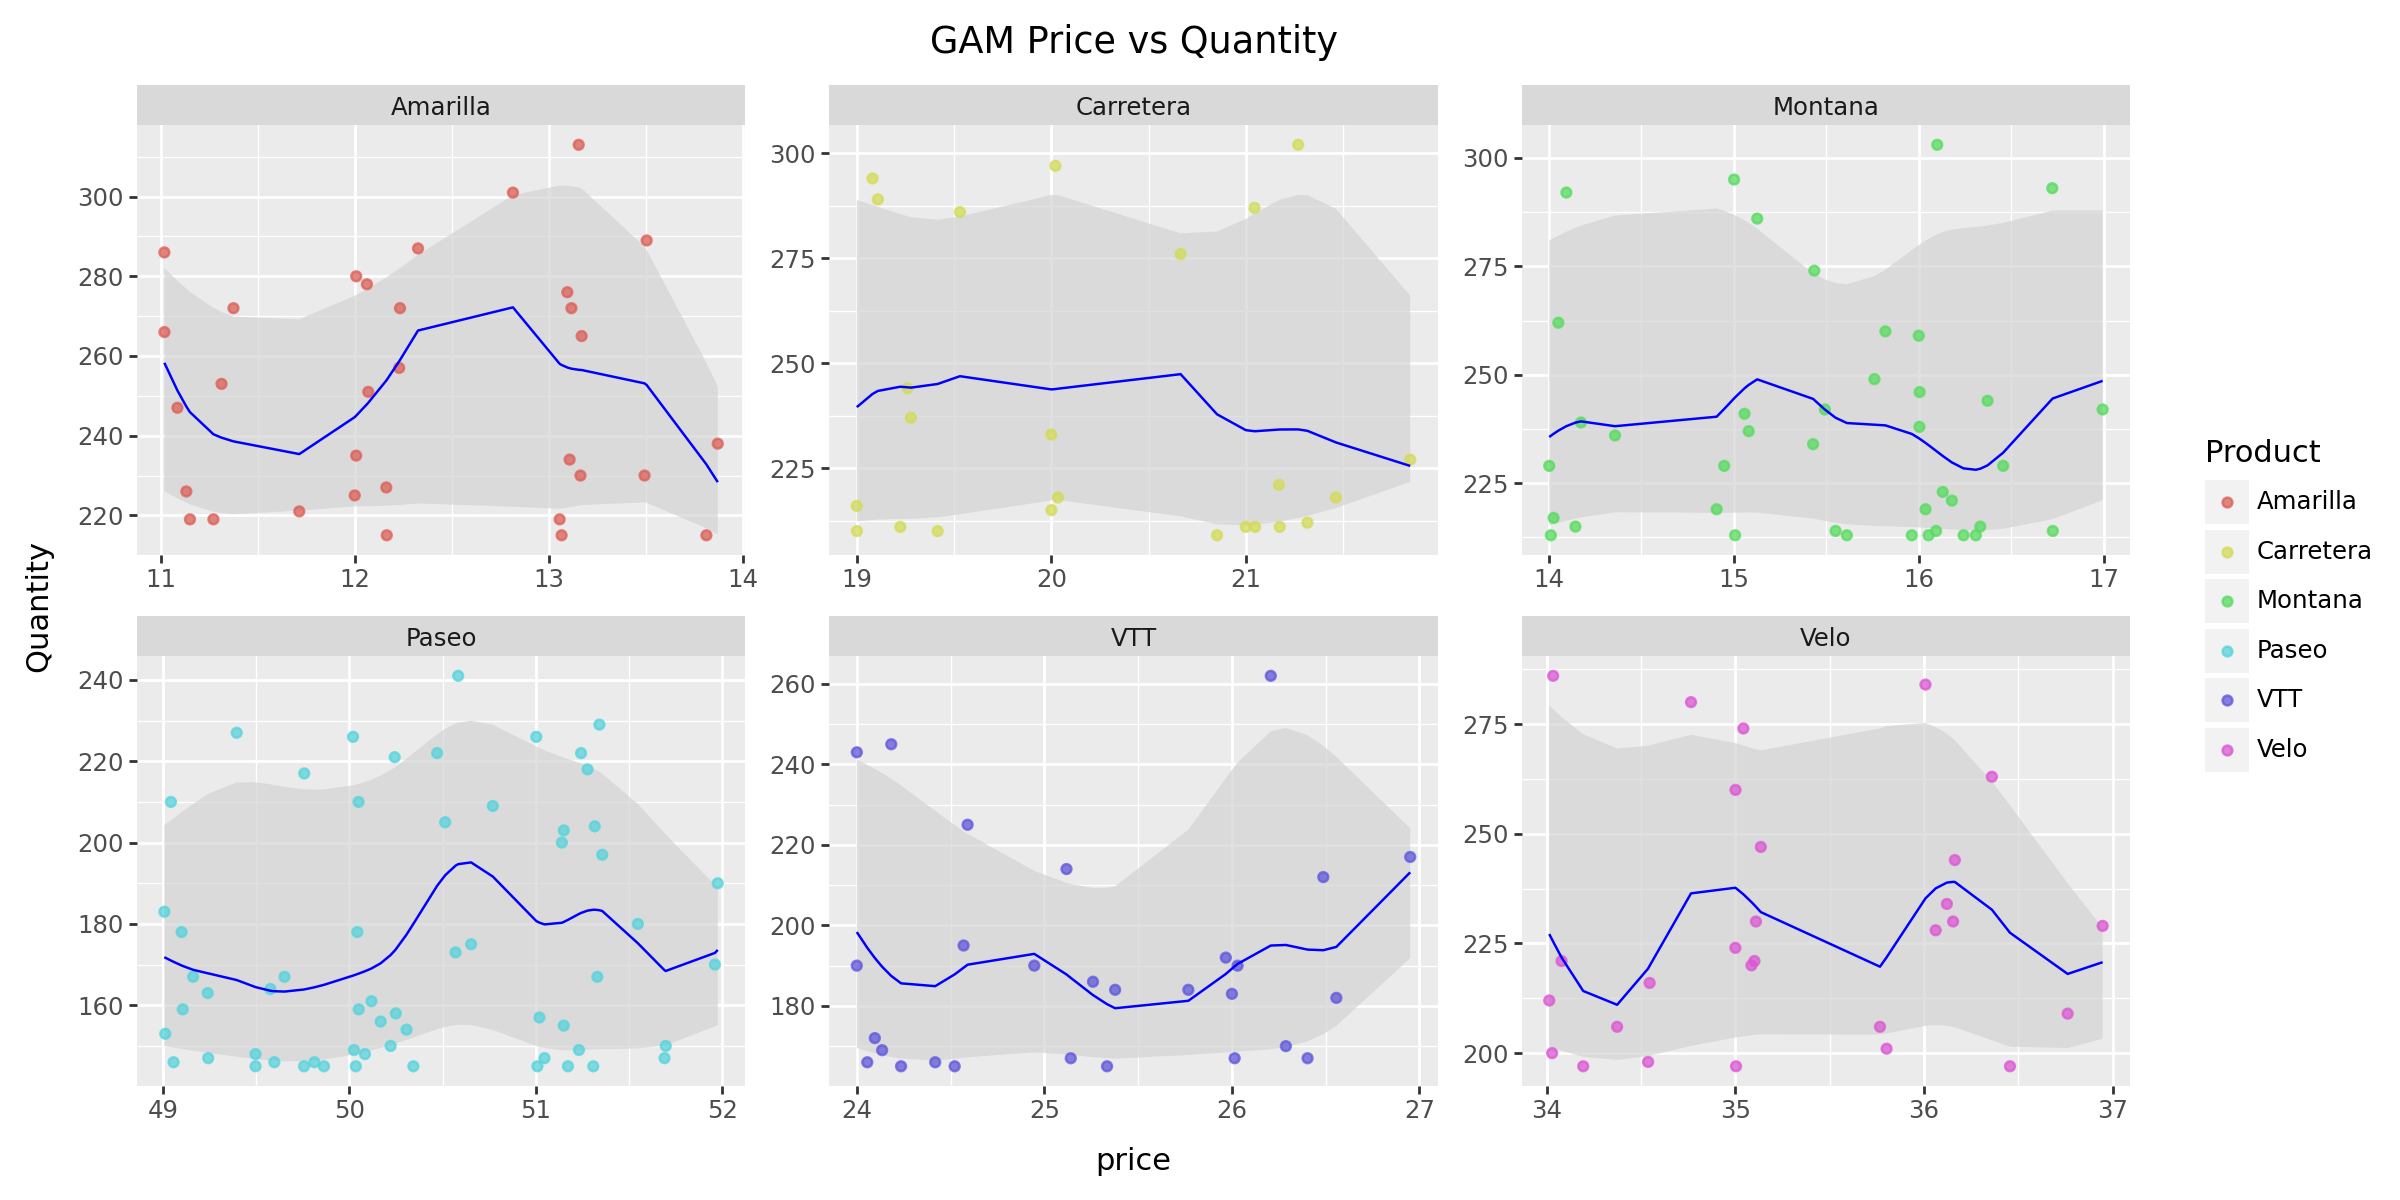

In [20]:
# Visualization of the model and prices within the bands
(ggplot(
    data = all_gam_results,
    mapping = aes(x='price', y='Quantity', color='Product', group= 'Product') ) +
    geom_ribbon(aes(ymax= 'pred_0.975', ymin= 'pred_0.025'), 
                fill='#d3d3d3', color= '#FF000000', alpha=0.7, show_legend=False) +
    geom_point(alpha=0.75) + 
    geom_line(aes(y='pred_0.5'), color='blue') +
    facet_wrap('Product', scales='free') + 
    labs(title='GAM Price vs Quantity') +
    theme(figure_size=(12,6))
)

### Optimize Price

In [21]:
# Calculate Revenue for each predicted price band
for col in all_gam_results.columns:
    if col.startswith('pred'):
        all_gam_results['revenue_' + col] = all_gam_results['price'] * all_gam_results[col]

# Actual revenue
all_gam_results['revenue_actual'] = all_gam_results['price'] * all_gam_results['Quantity']

# View
all_gam_results.sample(2)


,price,Product,Quantity,pred_0.025,pred_0.5,pred_0.975,revenue_pred_0.025,revenue_pred_0.5,revenue_pred_0.975,revenue_actual
1880,49.576559,Paseo,164.0,146.432088,163.569963,214.328137,7259.599072,8109.235923,10625.651561,8130.555685
2358,36.154028,Velo,230.0,205.976960,239.034725,271.643238,7446.896683,8642.068036,9820.997101,8315.426332


In [22]:
# Calculating where the predicted median revenue is the max
best_50 = (
    all_gam_results
    .groupby('Product')
    .apply(lambda x: x[x['revenue_pred_0.5'] == x['revenue_pred_0.5'].max()].head(1))
    .reset_index(level=0, drop=True)
)

# Calculating where the predicted 97.5% percentile revenue is the max
best_975 = (
    all_gam_results
    .groupby('Product')
    .apply(lambda x: x[x['revenue_pred_0.975'] == x['revenue_pred_0.975'].max()].head(1))
    .reset_index(level=0, drop=True)
)

# Calculating where the predicted 2.5% percentile revenue is the max
best_025 = (
    all_gam_results
    .groupby('Product')
    .apply(lambda x: x[x['revenue_pred_0.025'] == x['revenue_pred_0.025'].max()].head(1))
    .reset_index(level=0, drop=True)
)

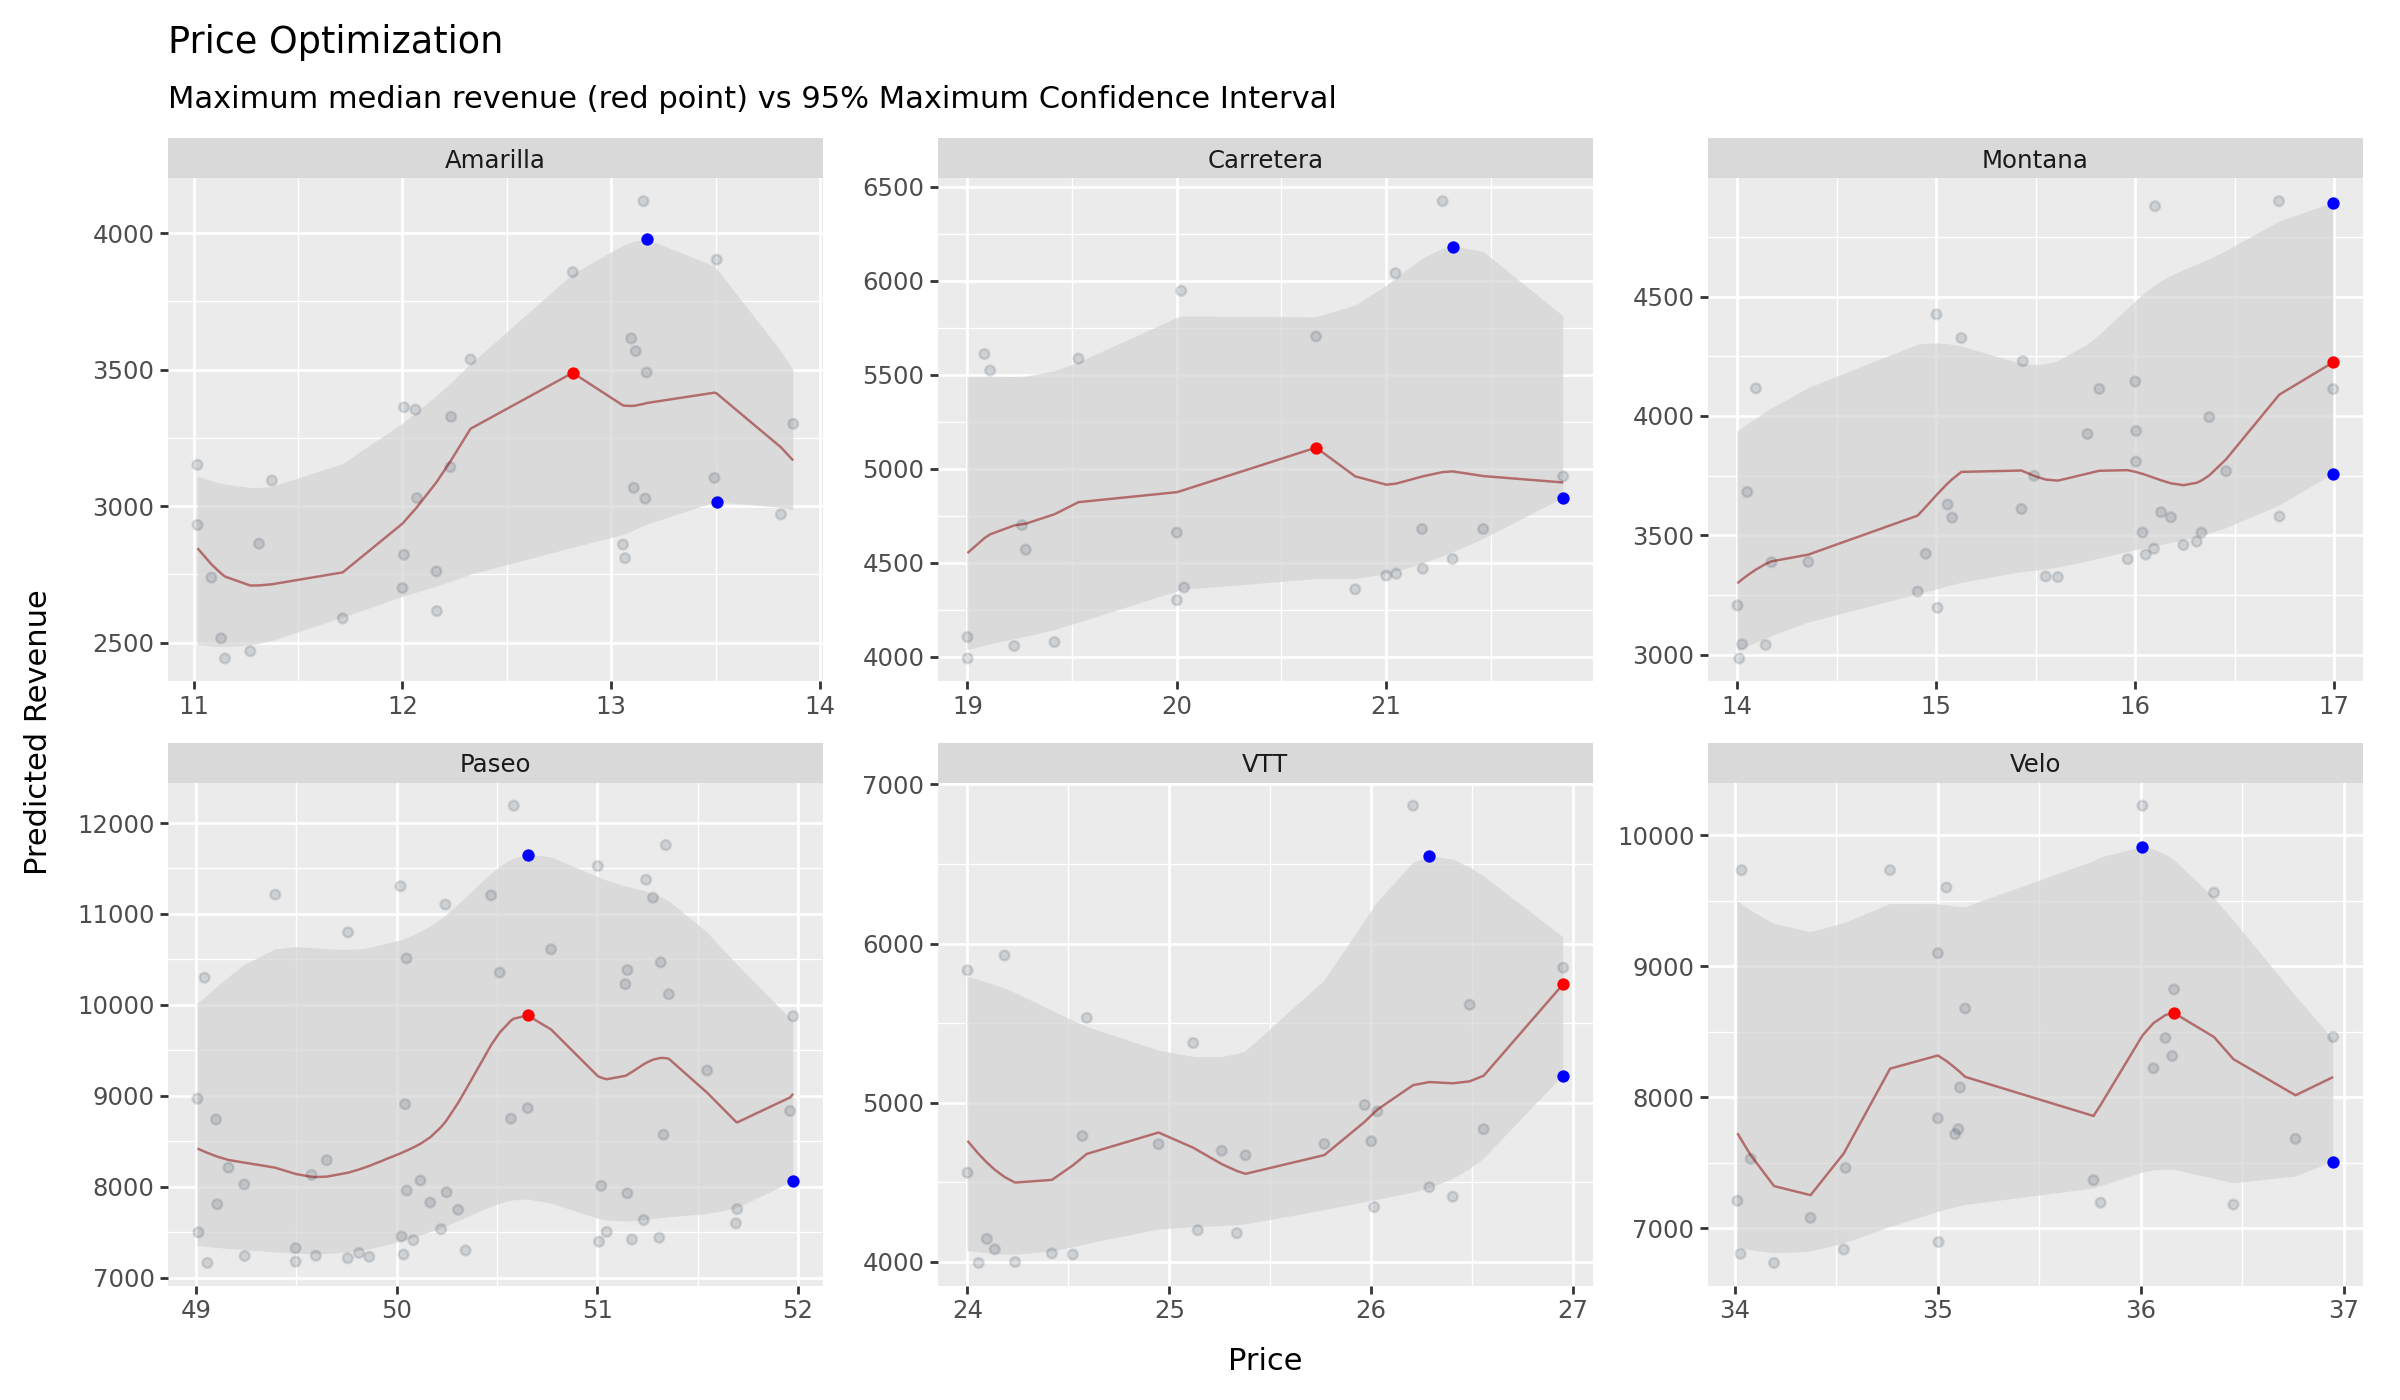

In [23]:
# Visualize the GAM Optimization Result
(ggplot(
    # Data
    data = all_gam_results,
    # Axes
    mapping = aes(x='price', y='revenue_pred_0.5', color='Product', group='Product') ) + 
# Adding the Band
geom_ribbon(aes(ymax= 'revenue_pred_0.975', ymin= 'revenue_pred_0.025'), 
                fill='#d3d3d3', color= '#FF000000', alpha=0.7, show_legend=False) +
# Adding the points
geom_point(aes(y='revenue_actual'), alpha=0.15, color="#2C3E50") +
# Adding 50th percentile line
geom_line(aes(y='revenue_pred_0.5'), alpha=0.5, color='darkred') +
# Addimg the 50th pct points
geom_point(data=best_50, color='red') + 
# Addimg the 97th pct points
geom_point(data=best_975, mapping= aes(y='revenue_pred_0.975'), color='blue') + 
# Addimg the 2.5th pct points
geom_point(data=best_025, mapping= aes(y='revenue_pred_0.025'), color='blue') + 
# Wraps by product
facet_wrap('Product', scales='free') + 
# Labels
labs(
    title='Price Optimization',
    subtitle='Maximum median revenue (red point) vs 95% Maximum Confidence Interval',
    x= 'Price',
    y= 'Predicted Revenue'
    ) +
theme(figure_size=(12,7))

)

In [24]:
# View optimum prices
best_50

,price,Product,Quantity,pred_0.025,pred_0.5,pred_0.975,revenue_pred_0.025,revenue_pred_0.5,revenue_pred_0.975,revenue_actual
363,12.815754,Amarilla,301.0,222.166878,272.210536,300.348296,2847.236073,3488.583283,3849.189898,3857.541972
725,20.665027,Carretera,276.0,213.523284,247.376537,280.907710,4412.464382,5112.042760,5804.965351,5703.547387
1119,16.994412,Montana,242.0,221.076855,248.594581,287.875226,3757.071058,4224.718613,4892.270060,4112.647588
1905,50.653262,Paseo,175.0,155.170906,195.125720,229.979194,7859.912594,9883.754260,11649.196415,8864.320896
2799,26.950991,VTT,217.0,191.848200,213.184543,224.114487,5170.499091,5745.534684,6040.107489,5848.365020
2359,36.163384,Velo,244.0,205.892132,239.013278,271.295617,7445.756298,8643.529032,9810.967670,8823.865787
